In [49]:
import numpy as np
from scipy import integrate
import numdifftools as nd
from scipy.optimize.nonlin import newton_krylov
import scipy.sparse.linalg as spla
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

In [50]:
''' inputs '''
T=1.0 # horizon length 
u_max=1.0 # free flow speed
rho_jam=1.0 # jam density
rho_a=0.2; rho_b=0.8; gama=0.15*L
costf="NonSep"
N,Nx,Nt,dt=np.loadtxt('list_NonSep_T1_N21_reg.dat')
N=int(N)
Nx=int(Nx)
Nt=int(Nt)
L=N
sol=np.loadtxt('Sol_NonSep_T1_N21_reg.dat')

In [51]:
''' functions '''
def U(rho): # Greenshields desired speed
    return u_max*(1-rho/rho_jam)

def f_mfg(u,r):
    if costf=="LWR":
        return 0.5*((U(r)-u)**2) # MFG-LWR
    elif costf=="Sep":
        return 0.5*((u/u_max)**2)-(u/u_max)+(r/rho_jam) # MFG-Separable
    elif costf=="NonSep":
        return 0.5*((u/u_max)**2)-(u/u_max)+((u*r)/(u_max*rho_jam)) # MFG-NonSeparable

def f_star_p(p,r): # 0<=u<=u_max
    if costf=="LWR":
        return U(r)-p # MFG-LWR
    elif costf=="Sep":
        return max(min(u_max*(1-p*u_max),u_max),0) # MFG-Separable
    elif costf=="NonSep":
        return max(min(u_max*(1-r/rho_jam-u_max*p),u_max),0) # MFG-NonSeparable

def rho_int(s): # initial density
    return rho_a+(rho_b-rho_a)*np.exp(-0.5*((s-0.5*L)/gama)**2) # 0<=rho<=rho_jam

### MFG solution

In [52]:
def solution(sol,rho,u,V,Q):
    for j in range(1,Nx+1):
        for n in range(0,Nt):
            rho[j,n]=sol[(j-1)*(Nt+1)+n]
            u[j,n]=sol[(Nt+1)*Nx+(j-1)*Nt+n]
            V[j,n]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
            Q[j,n]=rho[j,n]*u[j,n]
        rho[j,Nt]=sol[(j-1)*(Nt+1)+Nt]
        V[j,Nt]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
    for n in range(0,Nt+1): # periodic boundary conditions
        rho[0,n]=rho[Nx,n]
        V[0,n]=V[Nx,n]
    for n in range(0,Nt):
        u[0,n]=f_star_p(V[0,n+1]/dx,rho[0,n])
        Q[0,n]=rho[0,n]*u[0,n]
    return 0

""" MFG Solution """
rho_mfg=np.zeros((Nx+1,Nt+1))
u_mfg=np.zeros((Nx+1,Nt))
V_mfg=np.zeros((Nx+1,Nt+1))
Q_mfg=np.zeros((Nx+1,Nt))
solution(sol,rho_mfg,u_mfg,V_mfg,Q_mfg)
x_mfg=np.linspace(0,L,Nx+1)
t_mfg=np.linspace(0,T,Nt+1)

### Initial distribution - positions

Text(0.5, 0, 'x')

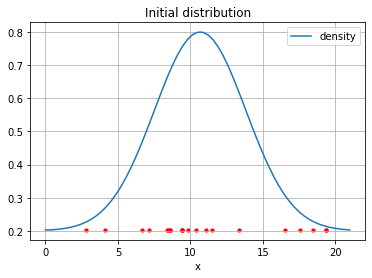

In [53]:
apt=40  # change apt to update random samples
def sample(pdf, nbr_samples, n_max=10**6):
    np.random.seed(apt)
    """ genearte a list of random samples from a given pdf
    suggests random samples between 0 and L 
    and accepts-rejects the suggestion with probability pdf(x) 
    """
    samples=[]
    n=0
    while len(samples)<nbr_samples and n<n_max:
        x=np.random.uniform(low=0,high=L)
        new_sample=pdf(x)
        assert new_sample>=0 and new_sample<=1
        if np.random.uniform(low=0,high=1) <=new_sample:
            samples += [x]
        n+=1
    return sorted(samples)


pos0=sample(rho_int,N)
Y=[rho_mfg[:,0].min()]*(N)
plt.plot(x_mfg,rho_mfg[:,0],label='density')
plt.scatter(pos0,Y,s=10,color='red')
plt.legend()
plt.grid()
plt.title("Initial distribution")
plt.xlabel('x')

### MFE-constructed controls

In [80]:
def location_int(pdf, x_MFG):
    """ generate initial locations from a given initial density pdf """
    random_loc=sample(pdf,N)
    loc=np.zeros(len(random_loc))
    for j in range(len(random_loc)):
        loc[j]=closest(x_MFG,random_loc[j])
    return loc 
def closest(lst, val):
    """ Find Closest number in a list """
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-val))]
def find_index(lst, val):
    """ find the index of val in lst"""
    ind='nan'
    for i in range(len(lst)):
        if lst[i]==val:
            ind=i
            break
    return ind
def control(u_MFG, x_MFG):
    lin,col=u_MFG.shape
    X=np.zeros((N,col))
    v=np.zeros((N,col))
    X[:,0]=location_int(rho_int, x_MFG)
    for n in range(col):
        for i in range(N):
            ind=find_index(x_MFG,X[i,n])
            v[i,n]=u_MFG[ind,n]
            new_x=X[i,n]+dt*v[i,n]
            if n < (col-1):
                X[i,n+1]=closest(x_MFG,new_x)
    return X,v
X_mfe,v_mfe=control(u_mfg,x_mfg)
# print('X_mfe=',X_mfe)
# print('v_mfe=',v_mfe)

Text(0, 0.5, 'v')

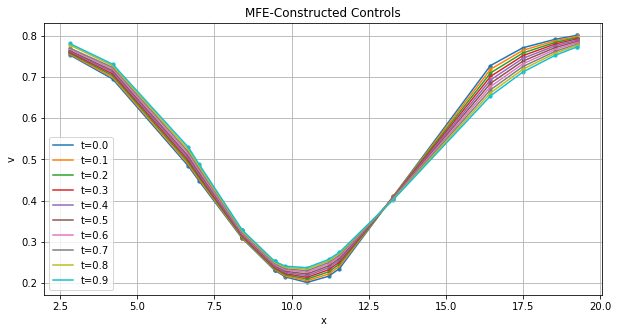

In [55]:
plt.figure(figsize=(10, 5))
for i in range(Nt):
    Y=[t_mfg[i]]*(N)
    plt.plot(X_mfe[:,i],v_mfe[:,i],label='t={t}'.format(t=round(t_mfg[i],3)))
    plt.scatter(X_mfe[:,i],v_mfe[:,i],s=10)
plt.legend()
plt.grid()
plt.title("MFE-Constructed Controls")
plt.xlabel('x')
plt.ylabel('v')

### Best response strategy

In [149]:
A=np.linspace(0,u_max,100)

X=np.zeros((N,Nt))
X[:,0]=location_int(rho_int, x_mfg)
v_bar=np.zeros(N)
J_mfe=np.zeros(N)
J_bar=np.zeros(N)
accuracy=np.zeros(N)

for i in range(N):
    J_mfe[i]=T*f_mfg(0.5*(v_mfe[i,0]+v_mfe[i,Nt-1]),0.5*(rho_int(X_mfe[i,0])+rho_int(X_mfe[i,Nt-1])))
    J_bar[i]=J_mfe[i]
    v_bar[i]=v_mfe[i,n]
    for k in range(1,len(A)):  
        for n in range(Nt):
            for j in range(N):
                    if n<Nt-1:
                        if j==i: X[j,n+1]=X[j,n]+dt*A[k] 
                        else: X[j,n+1]=X[j,n]+dt*v_mfe[j,n]
        J_test=T*f_mfg(A[k],0.5*(rho_int(X[i,0])+rho_int(X[i,Nt-1])))
        if J_bar[i]>J_test: 
            J_bar[i]=J_test
            v_bar[i]=A[k]
    accuracy[i]=J_mfe[i]-J_bar[i]
MaxRA=accuracy.max()/abs(J_mfe).max()
MeanRA=sum(accuracy)/sum(abs(J_mfe))
print('best responses=',v_bar)   
print('MaxRA=',MaxRA)
print('MeanRA=',MeanRA)
# print('J_mfe=',J_mfe)
# print('J_bar=',J_bar)

best responses= [0.78134684 0.73089734 0.52943442 0.48817461 0.32822309 0.32822309
 0.32822309 0.32822309 0.2524306  0.2524306  0.2524306  0.24050387
 0.2020202  0.22222222 0.25252525 0.44444444 0.72727273 0.76767677
 0.78787879 0.78787879 0.78787879]
MaxRA= 0.03893294614967209
MeanRA= 0.015199995132921494


### MFE-Constructed Control v.s. best response strategy

Text(0, 0.5, 'v')

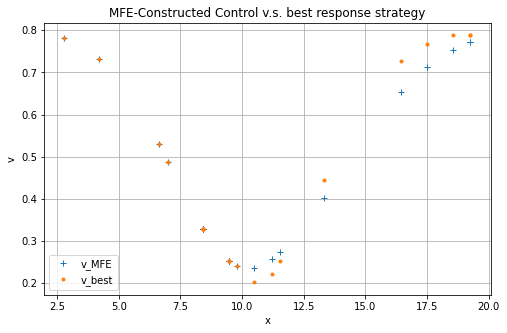

In [150]:
plt.figure(figsize=(8, 5))
plt.plot(X_mfe[:,Nt-1],v_mfe[:,Nt-1],'+',label='v_MFE')
plt.plot(X_mfe[:,Nt-1],v_bar,'.',label='v_best')
plt.legend()
plt.grid()
plt.title("MFE-Constructed Control v.s. best response strategy")
plt.xlabel('x')
plt.ylabel('v')

Text(0, 0.5, 'cost')

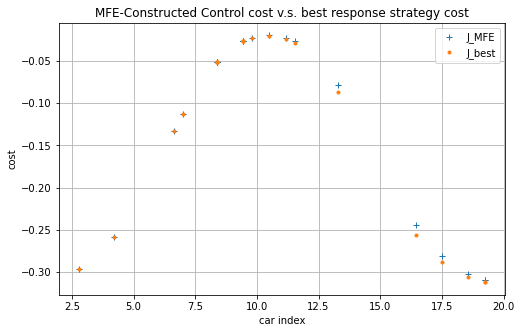

In [151]:
plt.figure(figsize=(8, 5))
plt.plot(X_mfe[:,Nt-1],J_mfe,'+',label='J_MFE')
plt.plot(X_mfe[:,Nt-1],J_bar,'.',label='J_best')
plt.legend()
plt.grid()
plt.title("MFE-Constructed Control cost v.s. best response strategy cost")
plt.xlabel('car index')
plt.ylabel('cost')